Best parameters:  {'activation': 'relu', 'batch_size': 30, 'hidden_layer_sizes': (3, 4, 4, 4), 'momentum': 0.9, 'tol': 0.05}
Best accuracy: 98.71%
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


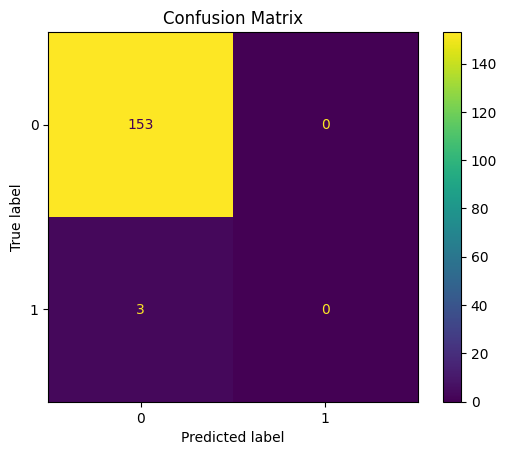

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9801 - loss: 0.1027
Test Loss:  0.09800132364034653
Test Accuracy:  0.9807692170143127


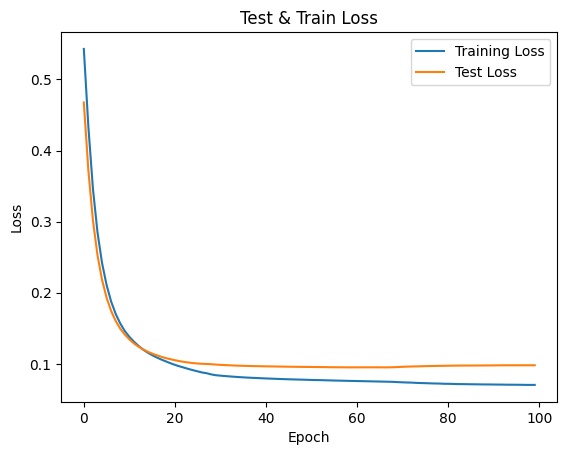

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.neural_network import MLPClassifier
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import GridSearchCV
from tensorflow import keras
from keras.optimizers import SGD
from keras.models import Sequential
from keras.layers import Dense, Dropout
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Read data, set features and target
df = pd.read_csv("filtered_data.csv")

X = df[['creatinine.enzymatic.method','LVEF']]
Y = df['death']

# Standardize data
scaler = StandardScaler();
normalized_X = scaler.fit_transform(X)

# Split data into train and test sets (75:25 split)
X_train, X_test, y_train, y_test = train_test_split(normalized_X, Y, test_size=0.25)

# Construct model
param_grid = {
    'hidden_layer_sizes': [(2,4, 4), (3, 4, 4, 4), (4, 4, 4, 4, 4)],
    'activation': ['relu', 'logistic', 'tanh'],
    'batch_size': [30, 50, 70],
    'momentum': [0.5, 0.7, 0.9],
    'tol': [0.01, 0.05, 0.02]
}
model = MLPClassifier(max_iter = 200, solver = 'sgd')
grid_search = GridSearchCV(estimator=model, param_grid=param_grid)
grid_search_fit = grid_search.fit(X_train, y_train)
print("Best parameters: ", grid_search_fit.best_params_)
print("Best accuracy: {:.2f}%".format(grid_search_fit.best_score_ * 100))
# model = keras.Sequential()
# model.add(keras.Input(shape=(2,)))
# model.add(keras.layers.Dense(4, activation='relu'))
# #model.add(Dropout(0.5))
# model.add(keras.layers.Dense(1, activation='sigmoid'))
# model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])
# best_model = MLPClassifier(
#     max_iter = 200, 
#     solver = 'sgd', 
#     hidden_layer_sizes = grid_search_fit.best_params_['hidden_layer_sizes'], 
#     activation = grid_search_fit.best_params_['activation'],
#     batch_size = grid_search_fit.best_params_['batch_size'],
#     momentum = grid_search_fit.best_params_['momentum'],
#     tol = grid_search_fit.best_params_['tol']
# )
best_model = keras.Sequential()
for i in range(grid_search_fit.best_params_['hidden_layer_sizes'][0]):
    best_model.add(keras.layers.Dense(4, activation=grid_search_fit.best_params_['activation']))
#model.add(Dropout(0.5))
best_model.add(keras.layers.Dense(1, activation='sigmoid'))
sgd = SGD(momentum=grid_search_fit.best_params_['momentum'])
best_model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])

# Train model
history = best_model.fit(X_train, y_train, epochs=100, batch_size = grid_search_fit.best_params_['batch_size'], validation_data=(X_test, y_test), verbose=0)                
# Evaluate
                           
y_pred_probabilities = best_model.predict(X_test)
y_pred = np.round(y_pred_probabilities)  # Convert to classes (continuous -> discrete)

# Create and visualize the confusion matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
chart = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix)
chart.plot()
plt.title('Confusion Matrix')
plt.show()

# Report results
loss, accuracy = best_model.evaluate(X_test, y_test)
print(f"Test Loss: ", loss)
print(f"Test Accuracy: ", accuracy)

# Plot test and training loss
training_loss = history.history['loss']
test_loss = history.history['val_loss']

plt.plot(training_loss, label='Training Loss')
plt.plot(test_loss, label='Test Loss')
plt.title('Test & Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Metrics if survival is the positive class, otherwise all except sensitivity are 0 (see below).

**Sensitivity**

$TPR = \frac{TP}{TP+FN}=\frac{155}{155+0}=1$

**Specificity**

$TNR = \frac{TN}{TN+FP}=\frac{0}{0+1}=0$

**F1-Score**

$F_1 = \frac{TP}{TP+\frac{1}{2}(FP+FN)}=\frac{155}{155+\frac{1}{2}(1+0)}=0.997$

**Precision**

$PPV = \frac{TP}{TP+FP}=\frac{155}{155+1}=0.994$

**Matthew's Correlation Cooefficient**

$MCC = \frac{TP*TN-FP*FN}{\sqrt{(TP+FP)*(TP+FN)*(TN+FP)*(TN*FN)}}=\frac{155*0-1*0}{\sqrt{(155+1)*(155+0)*(0+1)*(0*0)}}=0$

In [15]:
from sklearn.metrics import matthews_corrcoef

confusion_matrix_flattened = confusion_matrix.flatten()

tp = confusion_matrix_flattened[0]
tn = confusion_matrix_flattened[1]
fp = confusion_matrix_flattened[2]
fn = confusion_matrix_flattened[3]

# Evaluation metrics
sensitivity = tp / (tp + fn) if (tp + fn) != 0 else 0
specificity = tn / (tn + fp) if (tn + fp) != 0 else 0
precision   = tp / (tp + fp) if (tp + fp) != 0 else 0
f1_score    = 2 * (precision * sensitivity) / (precision + sensitivity) if (precision + sensitivity) != 0 else 0
mcc         = matthews_corrcoef(y_test, y_pred)

print(f"Sensitivity (Recall): {sensitivity}")
print(f"Specificity: {specificity}")
print(f"Precision: {precision}")
print(f"F1 Score: {f1_score}")
print(f"Matthews Correlation Coefficient (MCC): {mcc}")

Sensitivity (Recall): 1.0
Specificity: 0.0
Precision: 0.9935897435897436
F1 Score: 0.9967845659163987
Matthews Correlation Coefficient (MCC): 0.0
